In [1]:
import torch
import numpy as np
from PIL import Image

import matplotlib.pyplot as plt
from skimage.color import label2rgb
from tifffile import imread
from os import listdir

from yoeo.main import get_dv2_model, get_upsampler_and_expr

from interactive_seg_backend.configs import FeatureConfig, TrainingConfig
from interactive_seg_backend.file_handling import load_labels
from is_helpers import train_model_over_images, apply_model_over_images, eval_preds

import matplotlib.gridspec as gridspec
from matplotlib.patches import Rectangle
from matplotlib.colors import to_rgba


from typing import Literal

SEED = 10672
np.random.seed(SEED)
torch.manual_seed(SEED)
DEVICE = "cuda:1"

N CPUS: 110


In [2]:
# color_list = [[255, 255, 255], [31, 119, 180], [255, 127, 14], [44, 160, 44], [255, 0, 0]]
color_list = [[255, 255, 255], [0, 62, 131], [181, 209, 204], [250, 43, 0], [255, 184, 82]]
COLORS = np.array(color_list) / 255.0

In [3]:
dv2 = get_dv2_model(True, device=DEVICE)

model_path = "../trained_models/e5000_full_fit_reg.pth"
cfg_path = "../yoeo/models/configs/combined_no_shift.json"

upsampler, expr = get_upsampler_and_expr(model_path, cfg_path, device=DEVICE)

Using cache found in /home/ronan/.cache/torch/hub/ywyue_FiT3D_main


In [4]:
PATH = "fig_data/is_benchmark"
AllowedDatasets = Literal["Ni_superalloy_SEM", "T_cell_TEM", "Cu_ore_RLM"]
# dataset: tuple[AllowedDatasets, ...] = ("Ni_superalloy_SEM", "T_cell_TEM", "Cu_ore_RLM")
dataset: tuple[AllowedDatasets, ...] = ("Ni_superalloy_SEM", "T_cell_TEM", "Cu_ore_RLM")

TRAIN_IMG_FNAMES: dict[AllowedDatasets, list[str]] = {"Cu_ore_RLM": ["004", "028", "049", "077"], 
                                                      "Ni_superalloy_SEM": ["000", "001", "005", "007"], 
                                                      "T_cell_TEM": ["000", "005", "007", "026"]
                                                      }

all_classical_preds: dict[AllowedDatasets, dict[str, np.ndarray]] = {k: {} for k in dataset}
all_deep_preds: dict[AllowedDatasets, dict[str, np.ndarray]] = {k: {} for k in dataset}

In [5]:
for ds_name in dataset:
    chosen_dataset = ds_name
    feat_cfg = FeatureConfig()

    classical_train_cfg = TrainingConfig(feat_cfg, n_samples=-1, add_dino_features=False, classifier='xgb', classifier_params = {"class_weight": "balanced", "max_depth": 32},)
    classical_model, _ = train_model_over_images(chosen_dataset, classical_train_cfg, PATH, TRAIN_IMG_FNAMES[chosen_dataset], dv2, upsampler, expr)

    deep_train_cfg = TrainingConfig(feat_cfg, n_samples=-1, add_dino_features=True, classifier='xgb', classifier_params = {"class_weight": "balanced", "max_depth": 32},)
    deep_model, pca = train_model_over_images(chosen_dataset, deep_train_cfg, PATH, TRAIN_IMG_FNAMES[chosen_dataset], dv2, upsampler, expr)

    classical_preds = apply_model_over_images(chosen_dataset, classical_train_cfg, classical_model, PATH, dv2, upsampler, expr, verbose=True)
    deep_preds = apply_model_over_images(chosen_dataset, deep_train_cfg, deep_model, PATH, dv2, upsampler, expr, verbose=True, existing_pca=pca)

    all_classical_preds[ds_name] = classical_preds
    all_deep_preds[ds_name] = deep_preds

Finished featurising
Finished featurising
Finished featurising
Finished featurising
Finished featurising
Finished featurising
Finished featurising
Finished featurising
[00/23] - 000.tif
[10/23] - 010.tif
[20/23] - 020.tif
[00/23] - 000.tif
[10/23] - 010.tif
[20/23] - 020.tif
Finished featurising
Finished featurising
Finished featurising
Finished featurising
Finished featurising
Finished featurising
Finished featurising
Finished featurising
[00/30] - 000.tif
[10/30] - 010.tif
[20/30] - 020.tif
[00/30] - 000.tif
[10/30] - 010.tif
[20/30] - 020.tif
Finished featurising
Finished featurising
Finished featurising
Finished featurising
Finished featurising
Finished featurising
Finished featurising
Finished featurising
[00/27] - 004.tif
[10/27] - 049.tif
[20/27] - 065.tif
[00/27] - 004.tif
[10/27] - 049.tif
[20/27] - 065.tif


In [6]:
for chosen_dataset in dataset:
    classical_preds, deep_preds = all_classical_preds[chosen_dataset], all_deep_preds[chosen_dataset]
    miou_classical, miou_std_classical = eval_preds(chosen_dataset, classical_preds, PATH)
    miou_deep, miou_std_deep = eval_preds(chosen_dataset, deep_preds, PATH )
    print(f"======== {chosen_dataset} ========")
    print(f"mIoU_classical: {miou_classical:.4f}+/-{miou_std_classical:.4f} vs mIoU_deep: {miou_deep:.4f}+/-{miou_std_deep:.4f}\n")

======== Ni_superalloy_SEM ========
mIoU_classical: 0.5295+/-0.1350 vs mIoU_deep: 0.6896+/-0.1239

======== T_cell_TEM ========
mIoU_classical: 0.4513+/-0.1406 vs mIoU_deep: 0.6077+/-0.1572

======== Cu_ore_RLM ========
mIoU_classical: 0.8388+/-0.0545 vs mIoU_deep: 0.8625+/-0.0293



22/04/25

======== Ni_superalloy_SEM ========
mIoU_classical: 0.5398494931057901 vs mIoU_deep: 0.7031748112355668

======== T_cell_TEM ========
mIoU_classical: 0.389258450234841 vs mIoU_deep: 0.6698257898743982

======== Cu_ore_RLM ========
mIoU_classical: 0.8318250787943415 vs mIoU_deep: 0.8614422452045098

In [7]:
TITLE_FS = 25
LABEL_FS = 23
TICK_FS = 21
PAD = 60

def hide_axis_ticks(ax, frameoff: bool=True):
    ax.tick_params(which="both", bottom=False, top=False, left=False, right=False)
    ax.set_xticklabels([])
    ax.set_yticklabels([])

    if frameoff:
        ax.set_frame_on(False)


def add_stacked_rects(fig, subplot):
    outer_pos = subplot.get_position(fig) 

    x0, y0 = outer_pos.x0, outer_pos.y0
    width, height = outer_pos.width, outer_pos.height

    # Base color
    base_color = np.array(to_rgba('#bbbbbb'))

    for n in range(3):  # 3 stacked layers
        T = 0.005
        offset = n * T  # tweak this for separation between layers
        darken = 0.075 * n   # tweak this for how much darker each layer is
        color = np.clip(base_color - darken, 0, 1)  # slightly darker with each layer

        rect = Rectangle(
            (x0 + T + offset, y0 + T + offset),  # move up and right a bit
            width , height,
            transform=fig.transFigure,
            facecolor=color,
            zorder=-n - 1,  # stack order: bottom first
            alpha=1,
            linewidth=1,
            edgecolor='black'
        )
        fig.patches.append(rect)

plt.rcParams["font.family"] = "serif"

In [ ]:
def remap_seg(seg: np.ndarray, original_to_new: dict[int, int], add_plus_one_if_pred: bool=False) -> np.ndarray:
    out = np.zeros_like(seg)
    seg_copy = seg.copy()
    if add_plus_one_if_pred:
        seg_copy += 1
    for k, v in original_to_new.items():
        out = np.where(seg_copy == k, v, out)
    return out

remappings: dict[AllowedDatasets, dict[int, int]] = {"Ni_superalloy_SEM": {1:1, 2:2, 3:3}, 
                                                     "T_cell_TEM": {1:2, 2:1, 3:3}, 
                                                     "Cu_ore_RLM": {1:2, 2:1} }

(512, 512, 1) (512, 512, 3) (512, 512, 1)
[0 1 2]
[5 6 7]
[5 6 7]
[0 1 2]
[5 6 7]
[5 6 7]
[0 1 2]
[5 6 7]
[5 6 7]
[0 1 2]
[5 6 7]
[5 6 7]
(512, 512, 1) (512, 512, 3) (512, 512, 1)
[0 1 2]
[5 6 7]
[5 6 7]
[0 1 2]
[5 6 7]
[5 6 7]
[0 1 2]
[5 6 7]
[5 6 7]
[0 1 2]
[5 6 7]
[5 6 7]
(512, 512, 1) (512, 512, 3) (512, 512, 3)
[0 1]
[4 5]
[4 5]
[0 1]
[4 5]
[4 5]
[0 1]
[4 5]
[4 5]
[0 1]
[4 5]
[4 5]


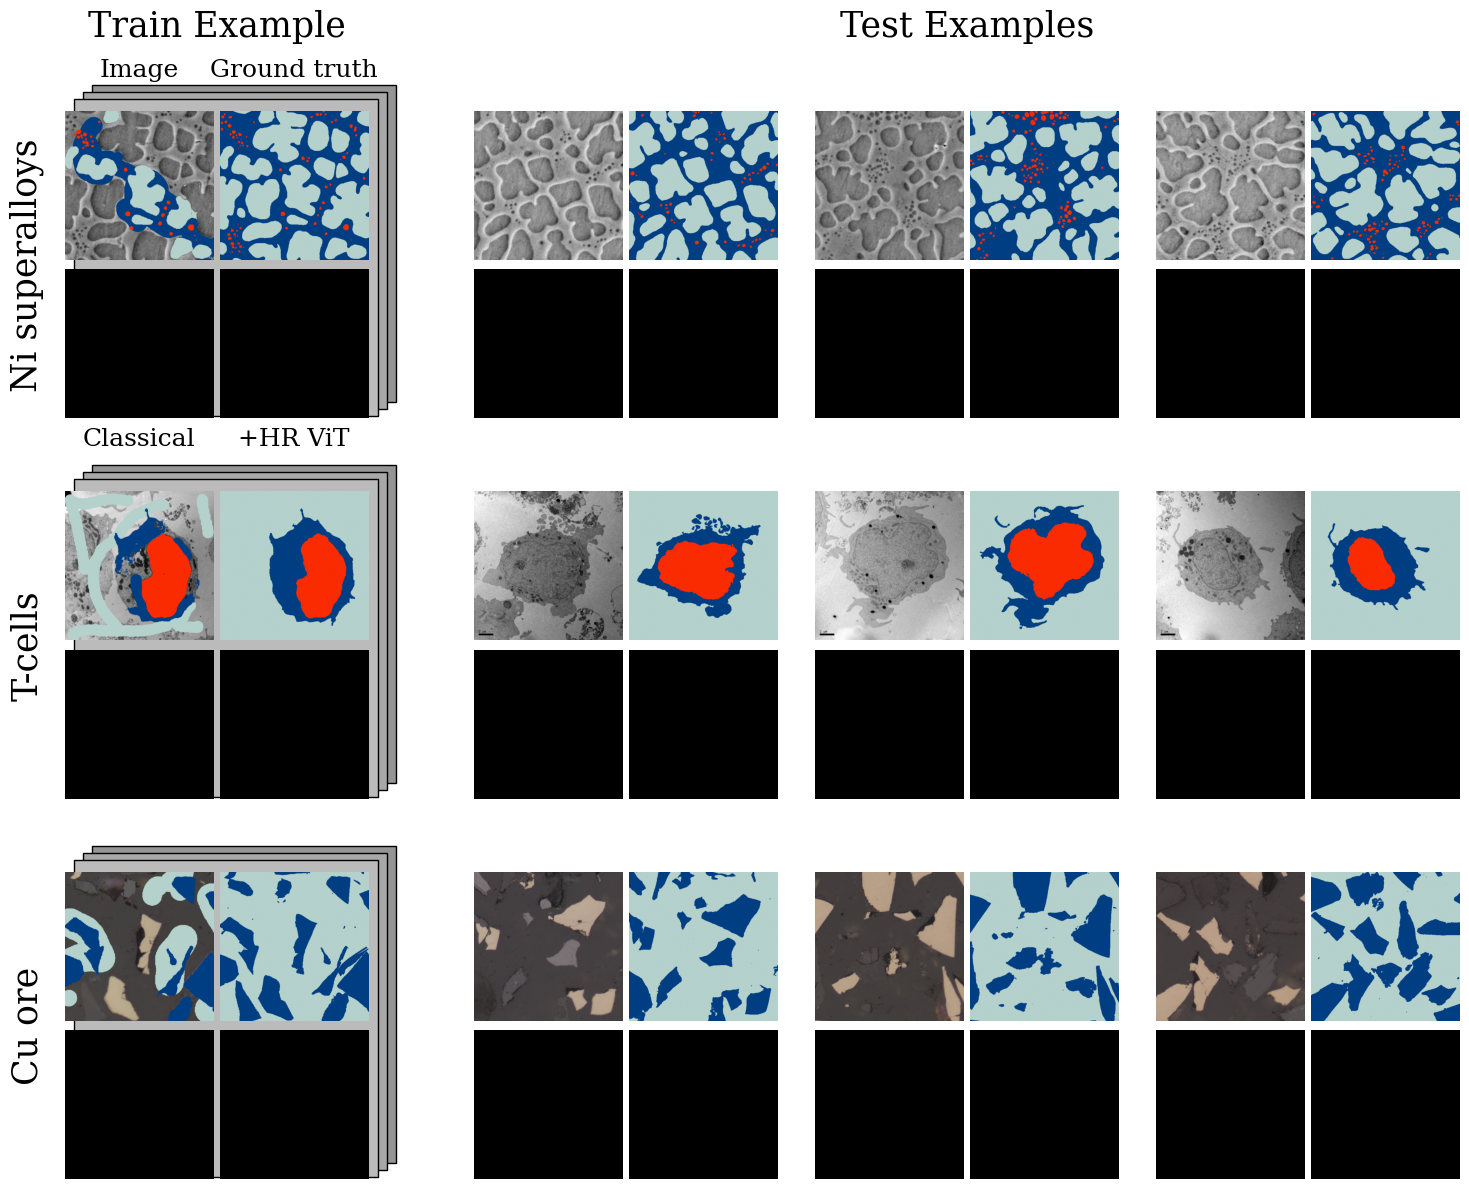

In [30]:

datasets: list[AllowedDatasets] = ["Ni_superalloy_SEM"] 
titles = ["Ni superalloys", "T-cells", "Cu ore"]



def do_fourplot(dataset: AllowedDatasets, filename: str, parent_grid, classical_preds: dict[str, np.ndarray], deep_preds: dict[str, np.ndarray],  is_train: bool, is_top_left_corner: bool = False):
    inner_grid = gridspec.GridSpecFromSubplotSpec(2, 2,
                subplot_spec=parent_grid, wspace=0.04, hspace=0.00)
    label_to_colour = remappings[dataset]

    def optional_crop(arr: np.ndarray) -> np.ndarray:
        O = 200
        if dataset == "Cu_ore_RLM":
            return arr[O:O+512, O:O+512]
        else:
            return arr

    for k in range(4):  # Each image (original + 3 derivatives)
        ax = plt.Subplot(fig, inner_grid[k // 2, k % 2])
        # ax.imshow(datasets[i][j][k], cmap='gray')
        hide_axis_ticks(ax)
        fig.add_subplot(ax)

        if is_very_top_corner and k < 2:
            ax.set_title(subfig_titles[k], fontsize=LABEL_FS-5, pad=25)
        elif is_very_top_corner and k >= 2:
            ax.set_xlabel(subfig_titles[k], fontsize=LABEL_FS-5, labelpad=0)
        
        if k == 0:
            img = optional_crop(imread(f"{PATH}/{dataset}/images/{filename}"))

            if is_train:
                labels = load_labels(f"{PATH}/{dataset}/labels/{filename}")
                if len(labels.shape) == 3:
                    labels = labels[0]
                labels = optional_crop(labels)
                remapped = remap_seg(labels, label_to_colour)
                labels_unsqueezed = np.expand_dims(remapped, -1)
    
                overlay = label2rgb(remapped, colors=COLORS[1:], kind='overlay', bg_label=0, image_alpha=1, alpha=1)
                if len(img.shape) == 2:
                    img = np.expand_dims(img, -1)
                print(labels_unsqueezed.shape, overlay.shape, img.shape)
                out = np.where(labels_unsqueezed, overlay * 255, img ).astype(np.uint8)
                img_with_labels = Image.fromarray(out)

                ax.imshow(img_with_labels, cmap='binary_r')
            else:
                ax.imshow(img, cmap='binary_r')
        elif k == 1:
            gt_seg = optional_crop(load_labels(f"{PATH}/{dataset}/segmentations/{filename}"))
            remapped = remap_seg(gt_seg, label_to_colour, add_plus_one_if_pred=True)
            ax.imshow(label2rgb(remapped, colors=COLORS[1:]))
        elif k == 2:
            classical_seg = optional_crop(classical_preds[f"{filename}"])
            remapped = remap_seg(classical_seg, label_to_colour, add_plus_one_if_pred=True)
            ax.imshow(label2rgb(remapped, colors=COLORS[1:]))
        elif k == 3:
            deep_seg = optional_crop(deep_preds[f"{filename}"])
            remapped = remap_seg(deep_seg, label_to_colour, add_plus_one_if_pred=True)
            ax.imshow(label2rgb(remapped, colors=COLORS[1:]))


fig = plt.figure(figsize=(18, 14))
outer_grid = gridspec.GridSpec(3, 5, width_ratios=[1, 0.1, 1, 1, 1], wspace=0.15, hspace=0.2)  # 3 rows (datasets), 4 columns (examples per dataset)
train_img_idx = [2, 0, 1]
rev = [True, True, True]

for i in range(3):  # Dataset rows
    chosen_dataset = list(all_classical_preds.keys())[i]
    train_filenames = TRAIN_IMG_FNAMES[chosen_dataset]
    test_img_fnames = [f for f in sorted(listdir(f"{PATH}/{chosen_dataset}/images")) if f not in train_filenames]
    if rev[i]:
        test_img_fnames = test_img_fnames[::-1]

    ax_train_label = plt.Subplot(fig, outer_grid[i, 0])
    ax_train_label.set_ylabel(titles[i], fontsize=TITLE_FS, labelpad=PAD-40, rotation=90, va='center')
    ax_test_label = plt.Subplot(fig, outer_grid[i, 3])
    if i == 0:
        ax_train_label.set_title('Train Example', fontsize=TITLE_FS, pad=PAD-10)
        ax_test_label.set_title('Test Examples', fontsize=TITLE_FS, pad=PAD-10)

    add_stacked_rects(fig, outer_grid[i, 0])
    hide_axis_ticks(ax_train_label)
    fig.add_subplot(ax_train_label)
    hide_axis_ticks(ax_test_label)
    fig.add_subplot(ax_test_label)

    outer_pos = outer_grid[i, 0].get_position(fig)
    # Coordinates of the 2x2 block to be used as background
    x0, y0 = outer_pos.x0, outer_pos.y0
    width, height = outer_pos.width, outer_pos.height

    subfig_titles = ["Image", "Ground truth", "Classical", '+HR ViT']

    # chosen_dataset = "Ni_superalloy_SEM" #datasets[i]
    img_fnames = sorted(listdir(f"{PATH}/{chosen_dataset}/images"))
    seg_fnames = sorted(listdir(f"{PATH}/{chosen_dataset}/segmentations"))

    train_example = train_filenames[train_img_idx[i]] + '.tif'

    for j in range(4):  # 4 examples per dataset

        is_very_top_corner = i == 0 and j == 0
        is_train_example = j == 0

        if j > 0:
            j += 1

        example_fname = train_example if j == 0 else test_img_fnames[j]

        do_fourplot(chosen_dataset, example_fname, outer_grid[i, j], all_classical_preds[chosen_dataset], all_deep_preds[chosen_dataset], is_train_example, is_very_top_corner)


plt.tight_layout(rect=[0, 0, 1, 0.96])  # Make space for suptitle
plt.savefig('fig_out/is_benchmark.png' ,bbox_inches='tight')